<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/maestria/teoria/11 - Ajuste de Umbrales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
#Este seteo de pandas sirve para que se puedan visualizar todas las columnas
#del dataframe#############################
pd.set_option('display.max_columns', None)#
###########################################

#Esta librería sirve para que oculte todo tipo de warnings que puedan 
#aparecer en el código. Generalmente si una función está por ser data de 
#baja o modificada en una librería, varias versiones antes aparecen estos
#tipos de advertencias cuando se ejecuta el código
import warnings###################
warnings.filterwarnings("ignore")#
##################################

#La función train_test_split sirve para dividir la base en dos partes
#Train y test para poder entrenar y validar un modelo#
from sklearn.model_selection import train_test_split##
######################################################

#Definimos las métricas
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

#Importo el modelo de arbol de decisión
#Importo lightgbm
import lightgbm 
import os
from google.colab import drive


In [2]:
#Levanto drive para poder almacenar los archivos
drive.mount("/content/drive")
contentFolder = "/content/drive/MyDrive/Austral - Data Mining"
if not os.path.exists(contentFolder):
    os.mkdir(contentFolder)

Mounted at /content/drive


In [3]:
data = pd.read_csv("{}/casosCovidProcesada.txt".format(contentFolder), sep=";")

# Configuración de umbral para bases desbalanceadas

## Métricas
![join.JPG](https://www.aprendemachinelearning.com/wp-content/uploads/2019/05/confusion_matix_example.png)


**_Matriz de Confusión_**: Es una herramienta que nos permite observar el desempeño un algoritmo que se utiliza en aprendizaje supervisado. Las columnas de la matriz representa el número de predicciones de cada clase, y cada fila representa las observaciones reales de cada una de las clases. Una de las ventajas de las matrices de confusión es que nos facilitan ver si el sistema está confundiendo dos clases.  

**_Accuracy - Efectividad_**: La efectividad nos indica a cuantas observaciones le acerté a la hora de predecir su target. En otras palabras es el porcentaje de predicciones correctas sobre el total de observaciones. Como dijimos anteriormente, esta métrica funciona correctamente solamente si las clases están balanceadas, es decir, tienen la misma cantidad de sucesos todos los valores.
$$Accuracy = \frac{truePositive+trueNegative}{totalSamples}$$

**_precisión_**: Es el número de casos positivos correctamente predichos dividido la suma de todos los positivos predichos por el modelo. Nos dirá cúan confiable es un modelo en responder si una observación es de una clase determinada
$$precision = \frac{truePositives}{truePositives+falsePositives}$$

**_recall_**: Es el número de casos positivos correctamente predichos sobre el total de casos reales positivos (esto incluye los verdaderos positivos y falsos negativos). El recall nos dirá cúan bien puede el modelo detectar a una clase.
$$recall = \frac{truePositives}{truePositives+falseNegatives}$$

1) Si tenemos alta precisión y alto recall: podemos indicar que el modelo puede manejar perfectamente a esa clase.
2) Si tenemos alta precisión y bajo recall: el modelo no puede detectar muy bien la clase, pero si lo hace es totalmente confiable.
3) Si tenemos baja precisión y alto recall: el modelo detecta bien la clase


**_Curva ROC_**: La curva ROC (receiver operating characteristic curve) es un gráfico que nos ayuda a visualizar la performance de un modelo de clasificación en todos los umbrales de clasificación. Esta curva se dibuja gracias a dos parámetros:
* True Positive Rate (TPR): Es un sinónimo de recall y se define de la siguente forma: 
$$\frac {truePositives}{truePositives + falsePositives} $$
* False Positive Rates (FPR):
$$\frac{falsePositives}{falsePositives + trueNegatives} $$

La curva ROC grafica TPR vs. FPR para los diferentes puntos que podemos tomar como umbrales. Si bajamos el umbral, más items clasificaremos como positivos.


![join.JPG](https://developers.google.com/static/machine-learning/crash-course/images/ROCCurve.svg?hl=es-419
)
Para poder computar los puntos de la curva ROC, una forma es correr un modelo (por ejemplo una regresión logística, n veces, todas con un umbral diferente. No obstante, no es una forma eficiente de hacerlo. Para que podamos correr de forma eficiente esta métrica se utiliza un algoritmo que nos permite generar esta información, es el AUC.


**_AUC_**: Área debajo de la curva ROC (Area Under the ROC Curve), mide el área de completa de la curva. Desde (0,0) a (1,1). Integral de la curva


![join.JPG](https://developers.google.com/static/machine-learning/crash-course/images/AUC.svg?hl=es-419)


In [ ]:
data.groupby("fallecido").size() / len(data)

fallecido
0    0.990844
1    0.009156
dtype: float64

In [5]:
X = data.drop(columns = ["id_evento_caso", "fallecido"])
y = data.fallecido
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print("Registros de la base de entrenamiento: {}, que es el {} de la base total".format(len(X_train), len(X_train)/len(X)))
print("Registros de la base de testeo: {}, que es el {} de la base total".format(len(X_test), len(X_test)/len(X)))

Registros de la base de entrenamiento: 5413117, que es el 0.6699999257359567 de la base total
Registros de la base de testeo: 2666163, que es el 0.3300000742640433 de la base total


### Entreno el modelo

In [6]:
learner = lightgbm.LGBMClassifier().fit(X_train, y_train)

In [7]:
probs = learner.predict_proba(X_test)[:,-1]

### G-Mean

Una de las opciones para buscar un umbral, es utilizar el valor óptimo entre los ratios de falsos positivos y verdaderos positivos. 

Volviendo a las métricas podemos decir:
* La sesibilidad: se calcula como el ratio de Verdaderos positivos
* La especificidad: se calcula como 1 - el ratio de falsos positivos.

La media geométrica o conocida como G-Mean es una métrica que nos ayuda a analizar modelos de clasificación con bases desbalanceadas. Nos permite revisar un balance entre la sensibilidad y la especificidad. para realizar dicho análisis.

$$GMean = \sqrt{Sensibilidad * especificidad}$$

Calculando el GMean para cada uno de los umbrales, luego se puede seleccionar aquél que genere el GMean más alto



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.009160, G-Mean=0.902


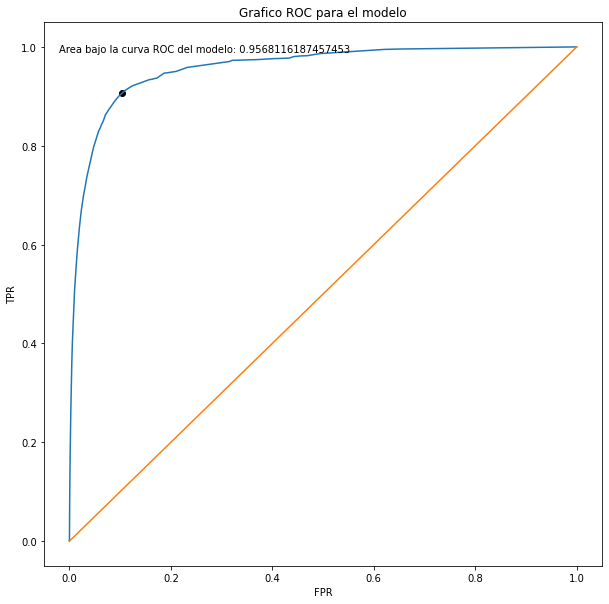

In [ ]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
areaBajoCurvaRoc = roc_auc_score(y_test, probs)
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()

### Índice de Youden

Otro parámetro para medir la efectividad global de la prueba es el índice de Youden, que suma los mal clasificados por la prueba diagnóstica según la siguiente fórmula:
$$J = sensibilidad + especificidad - 1$$

$$J = TPR - FPR$$

In [ ]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.009160


### Umbral óptimo utilizando la curva Precision-Recall

La curva Precision-recall se enfoca en la performance viendo los casos positivos (la clase minoritaria ) solamente.

La precisión describe cuán bueno es el modelo prediciendo la clase positiva. Decir recall es lo mismo que hablar de sensibilidad.

La curva _precision-recall_ se calcula construyendo predicciones con diversos umbrales. Se arma un gráfico de líneas para los umbrales en orden ascendente con el recall en el eje x y precision en el eje y.

Si queremos encontrar el mejor umbral que balancee de la mejor forma la precisión y el recall, podemos utilizar F score que sumariza la media armónica de ambas métricas


$$F-score = \frac{(2 * Precision * Recall)}{(Precision + Recall)} $$



In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, probs)

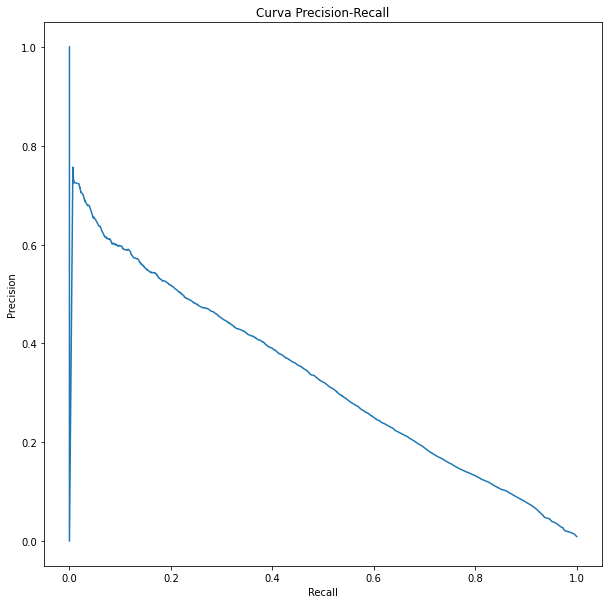

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Curva Precision-Recall")
plt.plot(recall, precision, label = "model")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(np.nan_to_num(fscore, nan=-99))
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.042508, F-Score=0.398


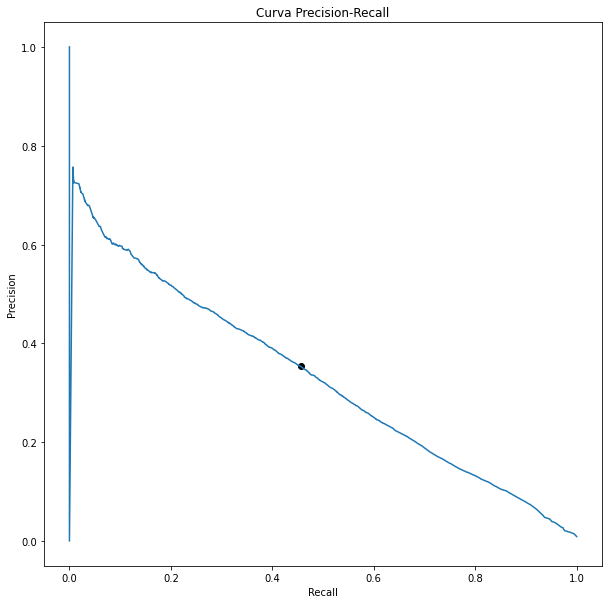

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Curva Precision-Recall")
plt.plot(recall, precision, label = "model")
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Usando K-S

In [17]:
target = "fallecidos"
X_test["probabilities"] =  probs
#Normalizo el score
X_test["normalizedScore"] = X_test.probabilities * 1000
#Armo los buckets cada 100 puntos
X_test["bucket"] = pd.cut(X_test.normalizedScore, np.array([0,100,200,300,400,500,600,700,800,900,1000]))
#Armo los deciles por scores
X_test['decile'] = pd.qcut(X_test.probabilities, 10, labels=False)
probsByDecile = X_test.groupby("decile").agg({"probabilities": ["min", "max"]})
probsByDecile.columns = ["Min Probability", "Max Probability"]
X_test[target] = y_test

measures = X_test.groupby("decile").agg({target : ["sum", "count"]})
measures.columns = ["Events", "Cases"]
measures["Non-events"] = measures["Cases"]-measures["Events"]
measures["Non-events Rate"] = (measures["Non-events"] / len(X_test[X_test[target] == 0])).round(2)
measures["Events Rate"] = (measures["Events"] / len(X_test[X_test[target] == 1])).round(2)
measures = measures.sort_index(ascending = False)
a = measures[["Non-events Rate", "Events Rate"]]\
                .cumsum()\
                .rename(columns={"Non-events Rate": "Cumulative Non-events Rate", 
                                 "Events Rate": "Cumulative Events Rate"})
measures = measures.join(a)
measures["KS"] =  measures["Cumulative Events Rate"] - measures["Cumulative Non-events Rate"]

probsByDecile = X_test.groupby("decile").agg({"probabilities": ["min", "max"]})
probsByDecile.columns = ["Min Probability", "Max Probability"]
measures = measures.join(probsByDecile)

measures[["Min Probability", "Max Probability", 
          "Cases","Non-events", "Events", "Non-events Rate", "Events Rate",
          "Cumulative Non-events Rate", "Cumulative Events Rate", "KS"]]

,Min Probability,Max Probability,Cases,Non-events,Events,Non-events Rate,Events Rate,Cumulative Non-events Rate,Cumulative Events Rate,KS
decile,,,,,,,,,,
9,0.011247,1.000000,266610,244569,22041,0.09,0.90,0.09,0.90,0.81
8,0.002705,0.011242,266594,265191,1403,0.10,0.06,0.19,0.96,0.77
7,0.001137,0.002705,266615,266179,436,0.10,0.02,0.29,0.98,0.69
6,0.000691,0.001137,266643,266409,234,0.10,0.01,0.39,0.99,0.60
5,0.000386,0.000691,265798,265666,132,0.10,0.01,0.49,1.00,0.51
4,0.000220,0.000386,266786,266713,73,0.10,0.00,0.59,1.00,0.41
3,0.000143,0.000220,266866,266834,32,0.10,0.00,0.69,1.00,0.31
2,0.000096,0.000143,256134,256115,19,0.10,0.00,0.79,1.00,0.21
1,0.000055,0.000096,273597,273585,12,0.10,0.00,0.89,1.00,0.11


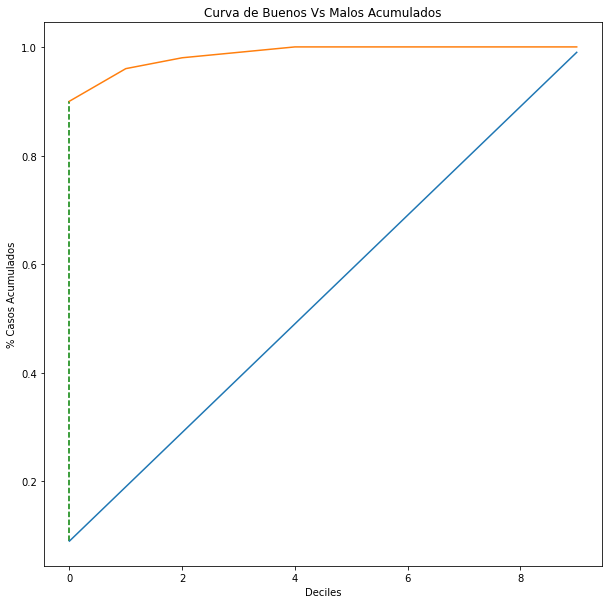

In [55]:
plt.figure(figsize=(10,10))
plt.title("Curva de Buenos Vs Malos Acumulados")
plt.plot(9-measures.index, measures["Cumulative Non-events Rate"].values)
plt.plot(9-measures.index, measures["Cumulative Events Rate"].values)

plt.vlines(x=(np.argmax(measures.KS.values)), 
           ymin=measures.loc[(9-np.argmax(measures.KS.values))]["Cumulative Non-events Rate"], 
           ymax=measures.loc[(9-np.argmax(measures.KS.values))]["Cumulative Events Rate"],
           linestyles="dashed",
           colors = "#008000")

plt.xlabel('Deciles')
plt.ylabel('% Casos Acumulados')
plt.show()

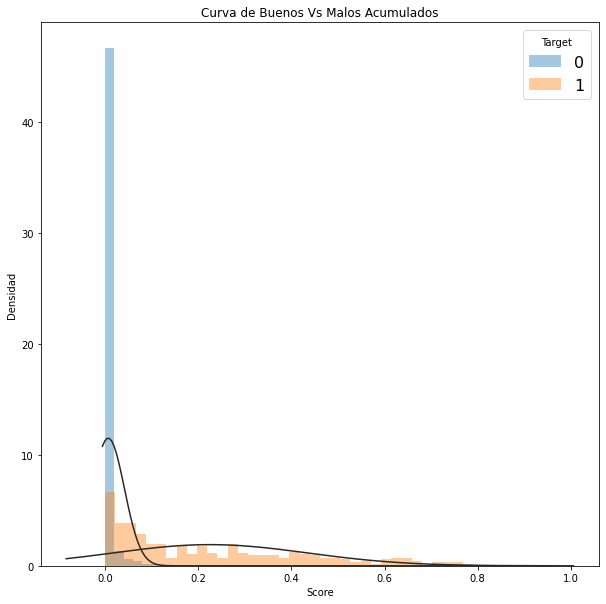

In [59]:
import seaborn as sns
from scipy.stats import norm

plt.figure(figsize=(10,10))
plt.title("Curva de Buenos Vs Malos Acumulados")

sns.distplot(X_test[X_test[target] == 0]['probabilities'],fit=norm, hist = True, kde=False, label = "0")
sns.distplot(X_test[X_test[target] == 1]['probabilities'],fit=norm, hist = True, kde=False, label = "1")    
plt.xlabel('Score')
plt.ylabel('Densidad')
plt.legend(prop={'size': 16}, title = 'Target')

In [63]:
quantiles = 20
target = "fallecidos"
X_test["probabilities"] =  probs
#Normalizo el score
X_test["normalizedScore"] = X_test.probabilities * 1000
#Armo los buckets cada 100 puntos
X_test["bucket"] = pd.cut(X_test.normalizedScore, np.array([0,100,200,300,400,500,600,700,800,900,1000]))
#Armo los deciles por scores
X_test['quantiles'] = pd.qcut(X_test.probabilities, quantiles, labels=False)
probsByDecile = X_test.groupby("quantiles").agg({"probabilities": ["min", "max"]})
probsByDecile.columns = ["Min Probability", "Max Probability"]
X_test[target] = y_test

measures = X_test.groupby("quantiles").agg({target : ["sum", "count"]})
measures.columns = ["Events", "Cases"]
measures["Non-events"] = measures["Cases"]-measures["Events"]
measures["Non-events Rate"] = (measures["Non-events"] / len(X_test[X_test[target] == 0])).round(2)
measures["Events Rate"] = (measures["Events"] / len(X_test[X_test[target] == 1])).round(2)
measures = measures.sort_index(ascending = False)
a = measures[["Non-events Rate", "Events Rate"]]\
                .cumsum()\
                .rename(columns={"Non-events Rate": "Cumulative Non-events Rate", 
                                 "Events Rate": "Cumulative Events Rate"})
measures = measures.join(a)
measures["KS"] =  measures["Cumulative Events Rate"] - measures["Cumulative Non-events Rate"]

probsByDecile = X_test.groupby("quantiles").agg({"probabilities": ["min", "max"]})
probsByDecile.columns = ["Min Probability", "Max Probability"]
measures = measures.join(probsByDecile)

measures[["Min Probability", "Max Probability", 
          "Cases","Non-events", "Events", "Non-events Rate", "Events Rate",
          "Cumulative Non-events Rate", "Cumulative Events Rate", "KS"]]

,Min Probability,Max Probability,Cases,Non-events,Events,Non-events Rate,Events Rate,Cumulative Non-events Rate,Cumulative Events Rate,KS
quantiles,,,,,,,,,,
19,0.035048,1.000000,133308,113928,19380,0.04,0.79,0.04,0.79,7.500000e-01
18,0.011247,0.035047,133302,130641,2661,0.05,0.11,0.09,0.90,8.100000e-01
17,0.004937,0.011242,131465,130509,956,0.05,0.04,0.14,0.94,8.000000e-01
16,0.002705,0.004936,135129,134682,447,0.05,0.02,0.19,0.96,7.700000e-01
15,0.001650,0.002705,133329,133072,257,0.05,0.01,0.24,0.97,7.300000e-01
14,0.001137,0.001650,133286,133107,179,0.05,0.01,0.29,0.98,6.900000e-01
13,0.000894,0.001137,133321,133182,139,0.05,0.01,0.34,0.99,6.500000e-01
12,0.000691,0.000894,133322,133227,95,0.05,0.00,0.39,0.99,6.000000e-01
11,0.000491,0.000691,133243,133166,77,0.05,0.00,0.44,0.99,5.500000e-01


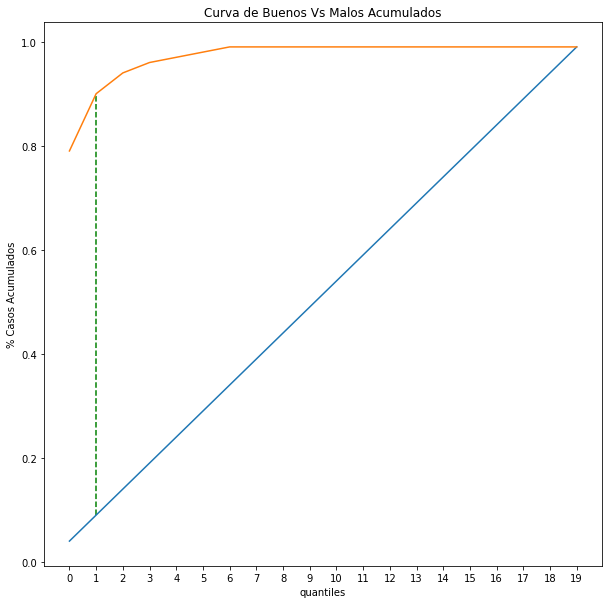

In [67]:
plt.figure(figsize=(10,10))
plt.title("Curva de Buenos Vs Malos Acumulados")
plt.plot(quantiles-1-measures.index, measures["Cumulative Non-events Rate"].values)
plt.plot(quantiles-1-measures.index, measures["Cumulative Events Rate"].values)
plt.xticks(ticks=measures.index, labels=measures.index)
plt.vlines(x=(np.argmax(measures.KS.values)), 
           ymin=measures.loc[(quantiles-1-np.argmax(measures.KS.values))]["Cumulative Non-events Rate"], 
           ymax=measures.loc[(quantiles-1-np.argmax(measures.KS.values))]["Cumulative Events Rate"],
           linestyles="dashed",
           colors = "#008000")

plt.xlabel('quantiles')
plt.ylabel('% Casos Acumulados')
plt.show()